---
# **Supervised Learning: Computer Vision**

# **Imágenes Histológicas**

---


Creado por: **V. D. Betancourt**




---
## **Índice**
---

- **Inputs**

- **Desarrollo del Proyecto: Imagen 1**

0. Carga de Imágenes
1. Transformación de Color
2. Umbralizar la Imagen
3. Limpieza de la Imagen
4. Rellenar el Fondo de la Imagen
5. Detectar Contornos
6. Cropear el Lumen
7. Extracción de Características Geométricas

- **Desarrollo del Proyecto: Imagen 1**

0. Carga de Imágenes
1. Transformación de Color
2. Umbralizar la Imagen
3. Limpieza de la Imagen
4. Rellenar el Fondo de la Imagen
5. Detectar Contornos
6. Cropear el Lumen
7. Extracción de Características Geométricas


---
## **Inputs**
---

Imágenes histológicas:
*  `histo_1.jpg`
*  `histo_2.jpg`

---
## **Desarrollo del Proyecto: Imagen 1**
---

#### 0) Cargar una de las imágenes histológicas

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

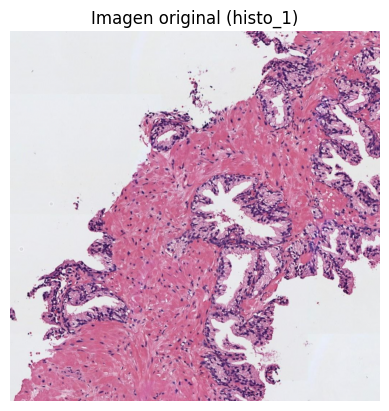

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

# Ruta de la imagen
path1 = 'histo_1.jpg'

# Leer la imagen en formato RGB usando skimage.io
img = io.imread(path1)

# Normalizar la imagen para que los píxeles estén en el rango [0, 1]
# No es necesario convertir a uint8, ya que skimage.io.imread devuelve un array numpy de tipo uint8
img_normalized = img / 255.0

# Visualizar la imagen
plt.imshow(img_normalized)
plt.title('Imagen original (histo_1)')
plt.axis('off')
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

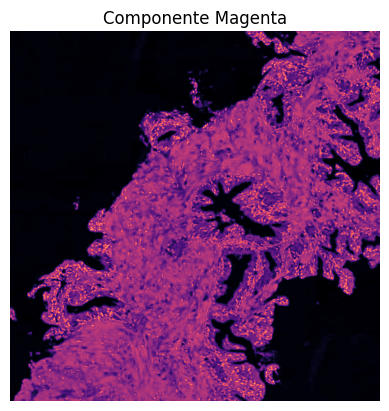

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Leer la imagen en formato RGB
path1 = 'histo_1.jpg'
img_rgb = cv2.imread(path1)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

# Convertir de RGB a CMYK
def rgb_to_cmyk(rgb):
    # Normalizar los valores RGB
    rgb = rgb / 255.0
    K = 1 - np.max(rgb, axis=2)
    C = (1-rgb[:,:,0]-K)/(1-K)
    M = (1-rgb[:,:,1]-K)/(1-K)
    Y = (1-rgb[:,:,2]-K)/(1-K)
    C[np.isnan(C)] = 0
    M[np.isnan(M)] = 0
    Y[np.isnan(Y)] = 0
    K[np.isnan(K)] = 0
    return np.stack((C, M, Y, K), axis=2)

# Convertir imagen a CMYK
cmyk_img = rgb_to_cmyk(img_rgb)

# Extraer la componente magenta
magenta_component = cmyk_img[:,:,1]

# Visualizar la componente magenta
plt.imshow(magenta_component, cmap='magma')
plt.title('Componente Magenta')
plt.axis('off')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

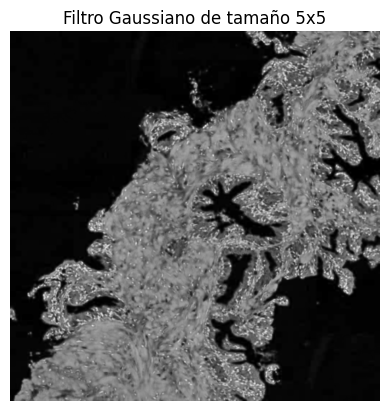

In [ ]:
#import cv2
#import matplotlib.pyplot as plt

# Si 'magenta_component' ya es una imagen de un solo canal (como resultado de la extracción del canal magenta de CMYK), está bien.
# De lo contrario, debe convertirse la imagen a un canal o escala de grises antes de este paso.

# Aplicar un filtro gaussiano de tamaño 5x5
# (5x5) es el tamaño del filtro y 0 es la desviación estándar
img_gaus = cv2.GaussianBlur(magenta_component, (5, 5), 0)

# Visualizar la imagen después de aplicar el filtro gaussiano
plt.imshow(img_gaus, cmap='gray')
plt.title('Filtro Gaussiano de tamaño 5x5')
plt.axis('off')
plt.show()


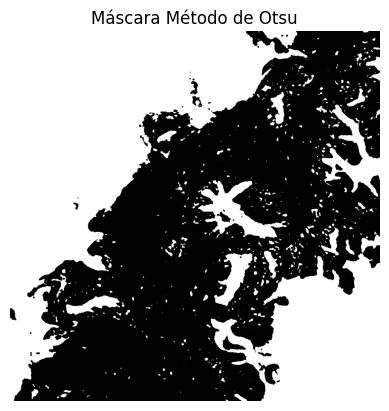

In [ ]:
#import cv2
#import matplotlib.pyplot as plt

# Asegurarse de que la imagen esté en el rango [0-255] y en formato uint8
img_gaus_uint8 = (img_gaus * 255).astype('uint8')

# Aplicar el Método de Otsu
# La función cv2.threshold devuelve el valor umbral y la imagen umbralizada
# Aquí, se utiliza 255 como valor máximo para ajustarse al rango de uint8
t, mask = cv2.threshold(img_gaus_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Opcional: Normalizar la máscara a [0, 1] si es necesario
mask = mask / 255

# Invertir los colores en la máscara si es necesario
inverted_mask = 1 - mask

# Visualizar la máscara resultante invertida
plt.imshow(inverted_mask, cmap='gray')
plt.title('Máscara Método de Otsu')
plt.axis('off')
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

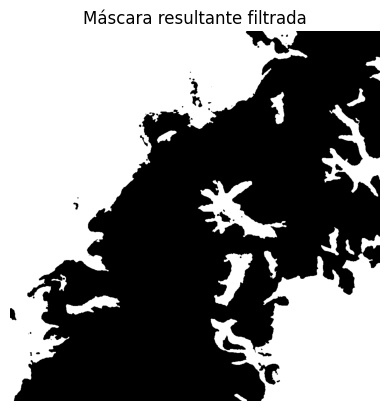

In [ ]:
from skimage import morphology
#import matplotlib.pyplot as plt

# Asegurarse de que 'inverted_mask' es de tipo booleano
bool_mask = inverted_mask.astype(bool)

# Utilizar remove_small_objects para eliminar objetos pequeños
# min_size=300 especifica el tamaño mínimo del objeto para ser conservado
filtered_mask = morphology.remove_small_objects(bool_mask, min_size=300)

# Visualizar la máscara resultante filtrada
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')
plt.title('Máscara resultante filtrada')
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

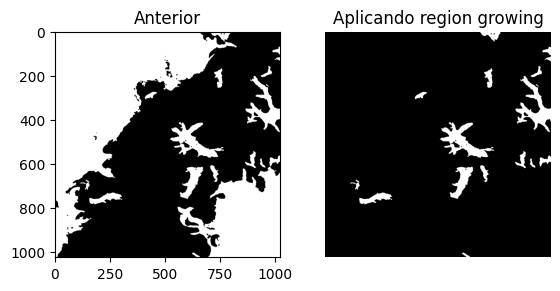

In [ ]:
#import cv2
#import numpy as np
#import matplotlib.pyplot as plt

# Crear una copia de la imagen y convertirla a formato entero de 8 bits (uint8)
lumen_filled_mask = (filtered_mask * 255).astype(np.uint8)

# Definir una imagen negra de referencia
h, w = lumen_filled_mask.shape
ref = np.zeros((h + 2, w + 2), np.uint8)

# Se utilizan dos semillas fijadas manualmente
cv2.floodFill(lumen_filled_mask, ref, (0, 0), 0)
cv2.floodFill(lumen_filled_mask, ref, (1000, 1000), 0)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(lumen_filled_mask, ref, (0, 0), 0)  # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(lumen_filled_mask, ref, (1000, 1000), 0)  # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

# Visualizar la imagen antes y después de aplicar region growing
fig, ax = plt.subplots(1, 2)
ax[0].imshow(filtered_mask, cmap='gray'), ax[0].set_title('Anterior')
ax[1].imshow(lumen_filled_mask, cmap='gray'), ax[1].set_title('Aplicando region growing')
plt.axis('off')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

<ipython-input-13-222bb10d4e46>:8: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  lumen_filled = scipy.ndimage.morphology.binary_fill_holes(lumen_filled_mask_bool)


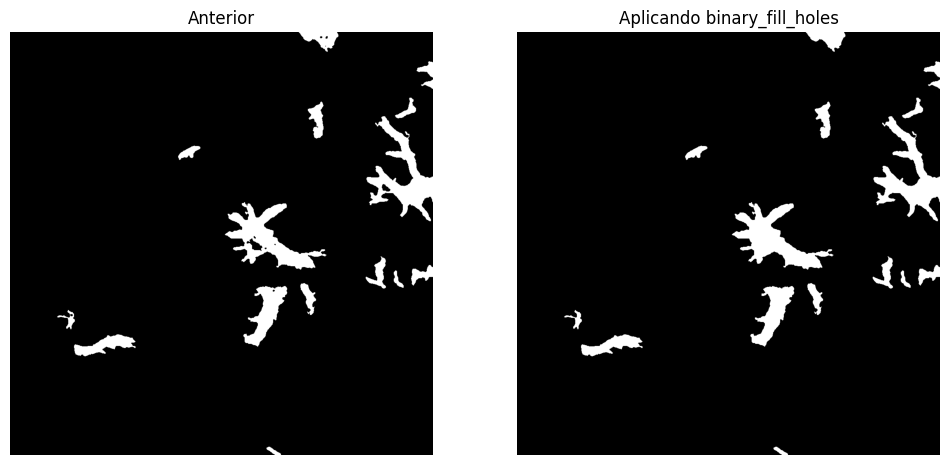

In [ ]:
import scipy.ndimage.morphology
#import matplotlib.pyplot as plt

# Asegurarse de que lumen_filled_mask es una matriz booleana
lumen_filled_mask_bool = lumen_filled_mask.astype(bool)

# Rellenar los agujeros en los objetos blancos
lumen_filled = scipy.ndimage.morphology.binary_fill_holes(lumen_filled_mask_bool)

# Mostrar las imágenes para comparar antes y después del relleno
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura

plt.subplot(1, 2, 1)
plt.imshow(lumen_filled_mask_bool, cmap='gray')
plt.title('Anterior')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lumen_filled, cmap='gray')
plt.title('Aplicando binary_fill_holes')
plt.axis('off')

plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

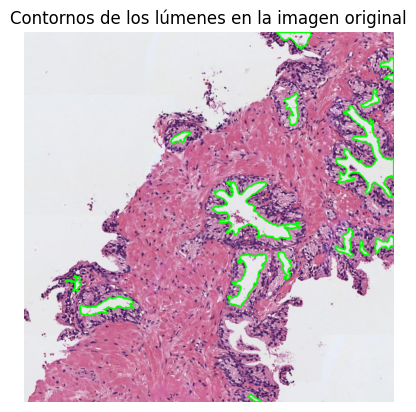

In [ ]:
from skimage.measure import label
#import cv2
#import matplotlib.pyplot as plt

# Asegurarse de que lumen_blanco es una matriz de enteros de 8 bits
lumen_filled_uint8 = lumen_filled.astype(np.uint8)

# Detectar contornos de los lúmenes en la máscara
contours, _ = cv2.findContours(lumen_filled_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar los contornos en la imagen original RGB
# Asumiendo que 'img' es la imagen original en formato RGB
contour_img = img.copy() # Crear una copia de la imagen original
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 3)  # Dibujar contornos en verde

# Mostrar la imagen con los contornos dibujados
plt.imshow(contour_img)
plt.title('Contornos de los lúmenes en la imagen original')
plt.axis('off')
plt.show()





#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

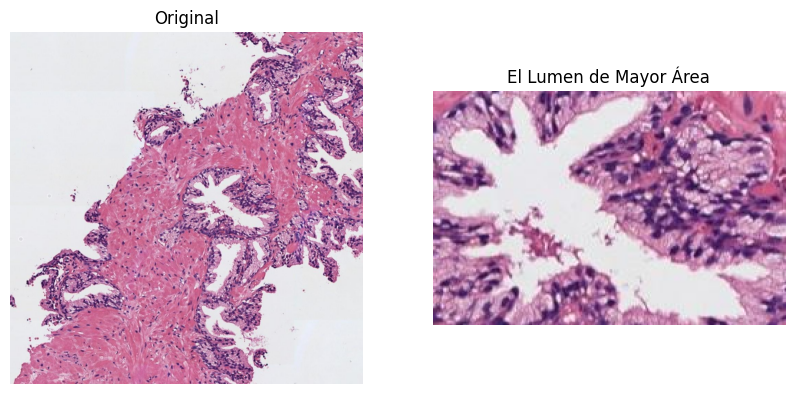

In [ ]:
#import cv2
#import matplotlib.pyplot as plt

# Asegurarse de que hay contornos antes de buscar el mayor
if contours:
    lumen_mayor = max(contours, key=cv2.contourArea)

    # Obtener las coordenadas del rectángulo delimitador del contorno
    x, y, w, h = cv2.boundingRect(lumen_mayor)

    # Recortar la región del lumen de mayor área en la imagen original
    cropped_rgb_image = img.copy()[y:y+h, x:x+w]

    # Visualizar la imagen original y el recorte del lumen
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)  # Asegurarse de que 'img' esté en formato RGB si se leyó con cv2.imread
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_rgb_image)
    plt.title('El Lumen de Mayor Área')
    plt.axis('off')

    plt.show()
else:
    print("No se encontraron contornos.")


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

Número de Objetos:  16


Visualización del Lumen de Mayor Área: 


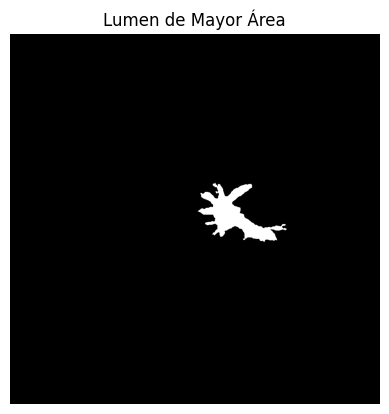

In [ ]:
from skimage.measure import label, regionprops
#import numpy as np
#import matplotlib.pyplot as plt

# Asegurarse de que 'lumen_blanco' es una máscara booleana
mask = lumen_filled.astype(bool)

# Etiquetar los objetos en la máscara
lab, num = label(mask, return_num=True)

# Calcular propiedades para todos los objetos etiquetados
props = regionprops(lab)

# Encontrar el objeto con mayor área (el lumen mayor)
lumen_mayor = max(props, key=lambda x: x.area)

# Crear una máscara para el lumen de mayor área
lumen_mayor_mask = lab == lumen_mayor.label

print('Número de Objetos: ', num)
print('\n')
print('Visualización del Lumen de Mayor Área: ')

# Visualizar el lumen de mayor área
plt.imshow(lumen_mayor_mask, cmap='gray')
plt.title('Lumen de Mayor Área')
plt.axis('off')
plt.show()


In [ ]:
#from skimage.measure import label, regionprops
#import numpy as np
#import matplotlib.pyplot as plt
from tabulate import tabulate
import math

# Asegurarse de que 'lumen_blanco' es una máscara booleana
mask = lumen_filled.astype(bool)

# Etiquetar los objetos en la máscara
lab, num = label(mask, return_num=True)

# Calcular propiedades para el lumen de mayor área
props = regionprops(lab)

# Encontrar el objeto con mayor área (el lumen mayor)
lumen_mayor = max(props, key=lambda x: x.area)

# Preparar los datos para tabular
caracteristicas = [
    ("Área", np.round(lumen_mayor.area, 4)),
    ("Área de la bounding box", np.round(lumen_mayor.bbox_area, 4)),
    ("Área convexa", np.round(lumen_mayor.convex_area, 4)),
    ("Excentricidad", np.round(lumen_mayor.eccentricity, 4)),
    ("Diámetro equivalente", np.round(lumen_mayor.equivalent_diameter, 4)),
    ("Extensión", np.round(lumen_mayor.extent, 4)),
    ("Longitud del eje mayor", np.round(lumen_mayor.major_axis_length, 4)),
    ("Longitud del eje menor", np.round(lumen_mayor.minor_axis_length, 4)),
    ("Orientación", np.round(lumen_mayor.orientation, 4)),
    ("Perímetro", np.round(lumen_mayor.perimeter, 4)),
    ("Solidez", np.round(lumen_mayor.solidity, 4)),
    ("Compacidad", np.round((4 * math.pi * lumen_mayor.area) / (lumen_mayor.perimeter ** 2), 4)),
    ("Rectangularidad", np.round(lumen_mayor.area / lumen_mayor.bbox_area, 4)),
    ("Diámetro Feret", np.round(lumen_mayor.feret_diameter_max, 4))
]

# Presentar las características en una tabla
print(tabulate(caracteristicas, headers=["Característica", "Valor"]))


Característica                Valor
-----------------------  ----------
Área                     14112
Área de la bounding box  40098
Área convexa             29267
Excentricidad                0.8472
Diámetro equivalente       134.045
Extensión                    0.3519
Longitud del eje mayor     238.616
Longitud del eje menor     126.776
Orientación                  1.0054
Perímetro                 1235.7
Solidez                      0.4822
Compacidad                   0.1161
Rectangularidad              0.3519
Diámetro Feret             259.077


---
## **Desarrollo del Proyecto: Imagen 2**
---

#### 0) Cargar una de las imágenes histológicas

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

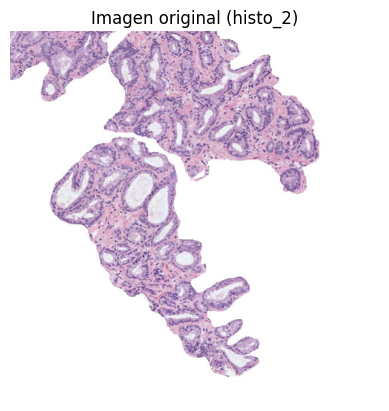

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

# Ruta de la imagen
path1 = 'histo_2.jpg'

# Leer la imagen en formato RGB usando skimage.io
img = io.imread(path1)

# Normalizar la imagen para que los píxeles estén en el rango [0, 1]
# No es necesario convertir a uint8, ya que skimage.io.imread devuelve un array numpy de tipo uint8
img_normalized = img / 255.0

# Visualizar la imagen
plt.imshow(img_normalized)
plt.title('Imagen original (histo_2)')
plt.axis('off')
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

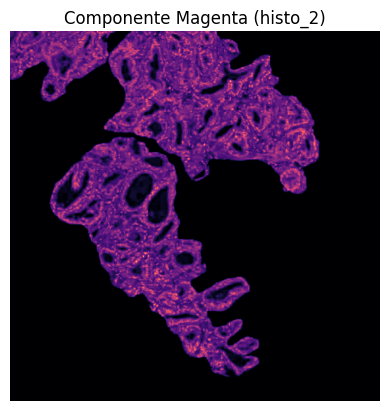

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Leer la imagen en formato RGB
path1 = 'histo_2.jpg'
img_rgb = cv2.imread(path1)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

# Convertir de RGB a CMYK
def rgb_to_cmyk(rgb):
    # Normalizar los valores RGB
    rgb = rgb / 255.0
    K = 1 - np.max(rgb, axis=2)
    C = (1-rgb[:,:,0]-K)/(1-K)
    M = (1-rgb[:,:,1]-K)/(1-K)
    Y = (1-rgb[:,:,2]-K)/(1-K)
    C[np.isnan(C)] = 0
    M[np.isnan(M)] = 0
    Y[np.isnan(Y)] = 0
    K[np.isnan(K)] = 0
    return np.stack((C, M, Y, K), axis=2)

# Convertir imagen a CMYK
cmyk_img = rgb_to_cmyk(img_rgb)

# Extraer la componente magenta
magenta_component = cmyk_img[:,:,1]

# Visualizar la componente magenta
plt.imshow(magenta_component, cmap='magma')
plt.title('Componente Magenta (histo_2)')
plt.axis('off')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

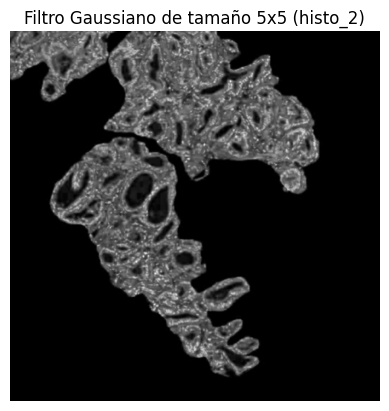

In [ ]:
#import cv2
#import matplotlib.pyplot as plt

# Si 'magenta_component' ya es una imagen de un solo canal (como resultado de la extracción del canal magenta de CMYK), está bien.
# De lo contrario, debe convertirse la imagen a un canal o escala de grises antes de este paso.

# Aplicar un filtro gaussiano de tamaño 5x5
# (5x5) es el tamaño del filtro y 0 es la desviación estándar
img_gaus = cv2.GaussianBlur(magenta_component, (5, 5), 0)

# Visualizar la imagen después de aplicar el filtro gaussiano
plt.imshow(img_gaus, cmap='gray')
plt.title('Filtro Gaussiano de tamaño 5x5 (histo_2)')
plt.axis('off')
plt.show()


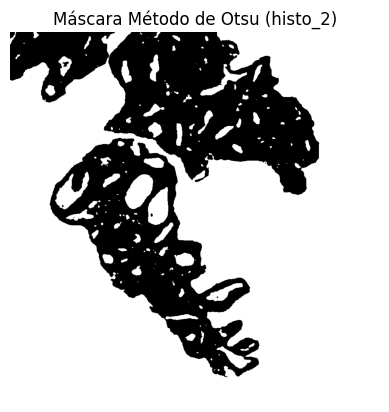

In [ ]:
#import cv2
#import matplotlib.pyplot as plt

# Asegurarse de que la imagen esté en el rango [0-255] y en formato uint8
img_gaus_uint8 = (img_gaus * 255).astype('uint8')

# Aplicar el Método de Otsu
# La función cv2.threshold devuelve el valor umbral y la imagen umbralizada
# Aquí, se utiliza 255 como valor máximo para ajustarse al rango de uint8
t, mask = cv2.threshold(img_gaus_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Opcional: Normalizar la máscara a [0, 1] si es necesario
mask = mask / 255

# Invertir los colores en la máscara si es necesario
inverted_mask = 1 - mask

# Visualizar la máscara resultante invertida
plt.imshow(inverted_mask, cmap='gray')
plt.title('Máscara Método de Otsu (histo_2)')
plt.axis('off')
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

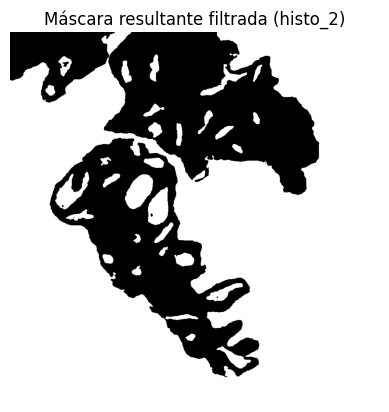

In [ ]:
from skimage import morphology
#import matplotlib.pyplot as plt

# Asegurarse de que 'inverted_mask' es de tipo booleano
bool_mask = inverted_mask.astype(bool)

# Utilizar remove_small_objects para eliminar objetos pequeños
# min_size=300 especifica el tamaño mínimo del objeto para ser conservado
filtered_mask = morphology.remove_small_objects(bool_mask, min_size=300)

# Visualizar la máscara resultante filtrada
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')
plt.title('Máscara resultante filtrada (histo_2)')
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

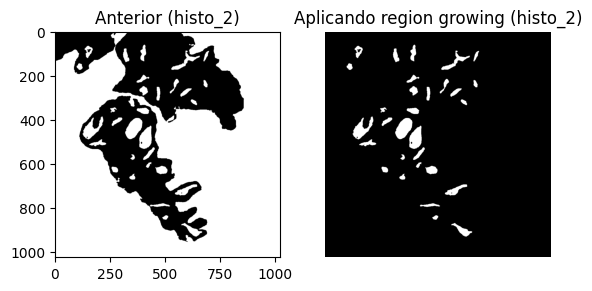

In [ ]:
#import cv2
#import numpy as np
#import matplotlib.pyplot as plt

# Crear una copia de la imagen y convertirla a formato entero de 8 bits (uint8)
lumen_filled_mask = (filtered_mask * 255).astype(np.uint8)

# Definir una imagen negra de referencia
h, w = lumen_filled_mask.shape
ref = np.zeros((h + 2, w + 2), np.uint8)

# Se utilizan dos semillas fijadas manualmente
cv2.floodFill(lumen_filled_mask, ref, (0, 0), 0)
cv2.floodFill(lumen_filled_mask, ref, (1000, 1000), 0)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(lumen_filled_mask, ref, (0, 0), 0)  # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(lumen_filled_mask, ref, (1000, 1000), 0)  # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

# Visualizar la imagen antes y después de aplicar region growing
fig, ax = plt.subplots(1, 2)
ax[0].imshow(filtered_mask, cmap='gray'), ax[0].set_title('Anterior (histo_2)')
ax[1].imshow(lumen_filled_mask, cmap='gray'), ax[1].set_title('Aplicando region growing (histo_2)')
plt.axis('off')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

<ipython-input-33-9a034a26dd95>:8: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  lumen_filled = scipy.ndimage.morphology.binary_fill_holes(lumen_filled_mask_bool)


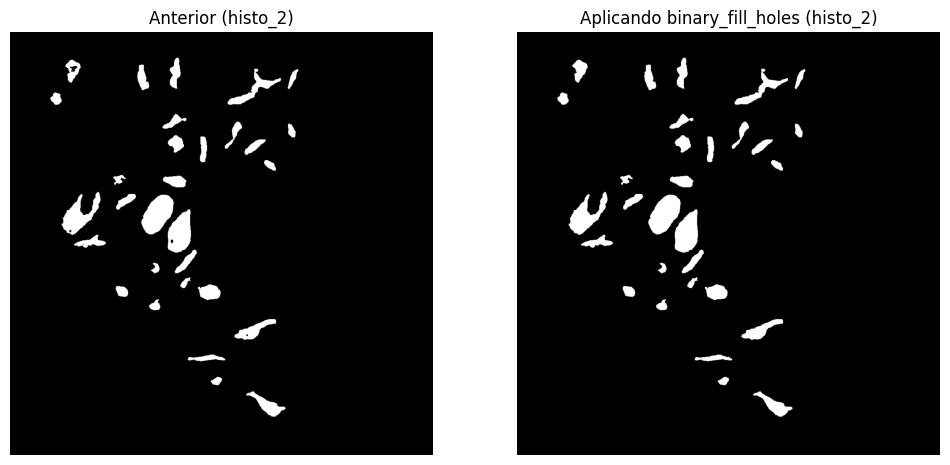

In [ ]:
import scipy.ndimage.morphology
#import matplotlib.pyplot as plt

# Asegurarse de que lumen_filled_mask es una matriz booleana
lumen_filled_mask_bool = lumen_filled_mask.astype(bool)

# Rellenar los agujeros en los objetos blancos
lumen_filled = scipy.ndimage.morphology.binary_fill_holes(lumen_filled_mask_bool)

# Mostrar las imágenes para comparar antes y después del relleno
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura

plt.subplot(1, 2, 1)
plt.imshow(lumen_filled_mask_bool, cmap='gray')
plt.title('Anterior (histo_2)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lumen_filled, cmap='gray')
plt.title('Aplicando binary_fill_holes (histo_2)')
plt.axis('off')

plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

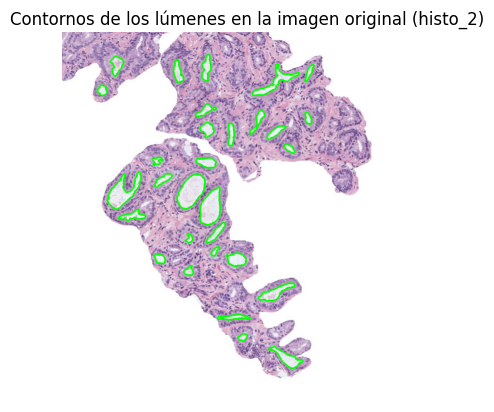

In [ ]:
from skimage.measure import label
#import cv2
#import matplotlib.pyplot as plt

# Asegurarse de que lumen_blanco es una matriz de enteros de 8 bits
lumen_filled_uint8 = lumen_filled.astype(np.uint8)

# Detectar contornos de los lúmenes en la máscara
contours, _ = cv2.findContours(lumen_filled_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar los contornos en la imagen original RGB
# Asumiendo que 'img' es la imagen original en formato RGB
contour_img = img.copy() # Crear una copia de la imagen original
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 3)  # Dibujar contornos en verde

# Mostrar la imagen con los contornos dibujados
plt.imshow(contour_img)
plt.title('Contornos de los lúmenes en la imagen original (histo_2)')
plt.axis('off')
plt.show()





#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

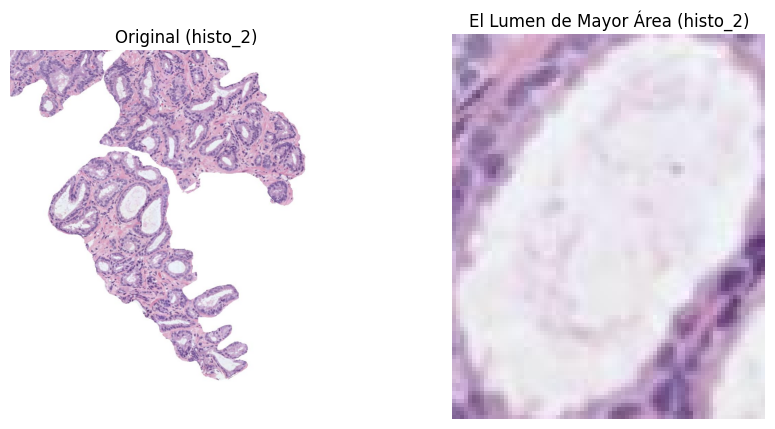

In [ ]:
#import cv2
#import matplotlib.pyplot as plt

# Asegurarse de que hay contornos antes de buscar el mayor
if contours:
    lumen_mayor = max(contours, key=cv2.contourArea)

    # Obtener las coordenadas del rectángulo delimitador del contorno
    x, y, w, h = cv2.boundingRect(lumen_mayor)

    # Recortar la región del lumen de mayor área en la imagen original
    cropped_rgb_image = img.copy()[y:y+h, x:x+w]

    # Visualizar la imagen original y el recorte del lumen
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)  # Asegurarse de que 'img' esté en formato RGB si se leyó con cv2.imread
    plt.title('Original (histo_2)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_rgb_image)
    plt.title('El Lumen de Mayor Área (histo_2)')
    plt.axis('off')

    plt.show()
else:
    print("No se encontraron contornos.")


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

Número de Objetos:  30


Visualización del Lumen de Mayor Área (histo_2): 


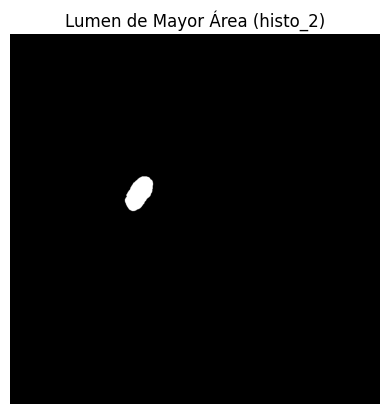

In [ ]:
from skimage.measure import label, regionprops
#import numpy as np
#import matplotlib.pyplot as plt

# Asegurarse de que 'lumen_blanco' es una máscara booleana
mask = lumen_filled.astype(bool)

# Etiquetar los objetos en la máscara
lab, num = label(mask, return_num=True)

# Calcular propiedades para todos los objetos etiquetados
props = regionprops(lab)

# Encontrar el objeto con mayor área (el lumen mayor)
lumen_mayor = max(props, key=lambda x: x.area)

# Crear una máscara para el lumen de mayor área
lumen_mayor_mask = lab == lumen_mayor.label

print('Número de Objetos: ', num)
print('\n')
print('Visualización del Lumen de Mayor Área (histo_2): ')

# Visualizar el lumen de mayor área
plt.imshow(lumen_mayor_mask, cmap='gray')
plt.title('Lumen de Mayor Área (histo_2)')
plt.axis('off')
plt.show()


In [ ]:
#from skimage.measure import label, regionprops
#import numpy as np
#import matplotlib.pyplot as plt
from tabulate import tabulate
import math

# Asegurarse de que 'lumen_blanco' es una máscara booleana
mask = lumen_filled.astype(bool)

# Etiquetar los objetos en la máscara
lab, num = label(mask, return_num=True)

# Calcular propiedades para el lumen de mayor área
props = regionprops(lab)

# Encontrar el objeto con mayor área (el lumen mayor)
lumen_mayor = max(props, key=lambda x: x.area)

# Preparar los datos para tabular
caracteristicas = [
    ("Área", np.round(lumen_mayor.area, 4)),
    ("Área de la bounding box", np.round(lumen_mayor.bbox_area, 4)),
    ("Área convexa", np.round(lumen_mayor.convex_area, 4)),
    ("Excentricidad", np.round(lumen_mayor.eccentricity, 4)),
    ("Diámetro equivalente", np.round(lumen_mayor.equivalent_diameter, 4)),
    ("Extensión", np.round(lumen_mayor.extent, 4)),
    ("Longitud del eje mayor", np.round(lumen_mayor.major_axis_length, 4)),
    ("Longitud del eje menor", np.round(lumen_mayor.minor_axis_length, 4)),
    ("Orientación", np.round(lumen_mayor.orientation, 4)),
    ("Perímetro", np.round(lumen_mayor.perimeter, 4)),
    ("Solidez", np.round(lumen_mayor.solidity, 4)),
    ("Compacidad", np.round((4 * math.pi * lumen_mayor.area) / (lumen_mayor.perimeter ** 2), 4)),
    ("Rectangularidad", np.round(lumen_mayor.area / lumen_mayor.bbox_area, 4)),
    ("Diámetro Feret", np.round(lumen_mayor.feret_diameter_max, 4))
]

# Presentar las características en una tabla
print(tabulate(caracteristicas, headers=["Característica (histo_2)", "Valor"]))


Característica (histo_2)        Valor
--------------------------  ---------
Área                        4887
Área de la bounding box     7488
Área convexa                5021
Excentricidad                  0.8353
Diámetro equivalente          78.8817
Extensión                      0.6526
Longitud del eje mayor       106.613
Longitud del eje menor        58.617
Orientación                   -0.5614
Perímetro                    280.392
Solidez                        0.9733
Compacidad                     0.7811
Rectangularidad                0.6526
Diámetro Feret               105.679
